In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy.random as random
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("./")

In [2]:
from autoencode import AEEnsemble
from models import Classifier
from datasets import SupervisedDataset, UnsupervisedDataset

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = AEEnsemble(
    convolutional_encoding=False, 
    device=device, 
    activ=nn.ReLU
)
ae.load(prefix="real")

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


Encoded session 1, 10000 spikes
Learning manifold for latent embeddings


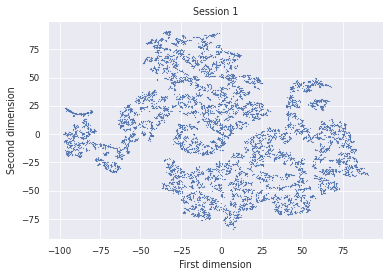

Encoded session 43, 10000 spikes
Learning manifold for latent embeddings


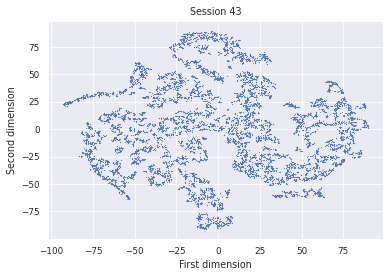

Encoded session 30, 10000 spikes
Learning manifold for latent embeddings


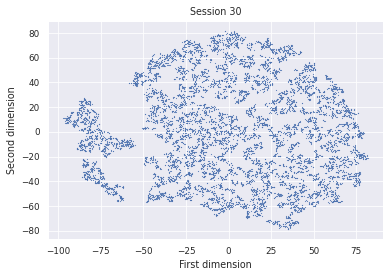

Encoded session 84, 10000 spikes
Learning manifold for latent embeddings


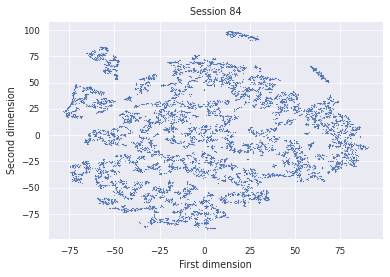

In [4]:
from sklearn.manifold import TSNE
import seaborn as sns

sns.set_theme()
sns.set_context("paper")

tsne = TSNE(n_components=2)

for e, d in zip(ae.encoders, ae.decoders):
    e.eval()
    d.eval()
for idx in [0, 42, 29, 83]:
    unsup_data = UnsupervisedDataset("/export/gaon1/data/jteneggi/DL/alm", session_idx=[idx])
    
    spikes_N = sum([len(ch) for ch, _ in unsup_data])
    spikes = np.zeros((spikes_N, 39))
    i = 0
    for ch, _ in unsup_data:
        for spike in ch:
            spikes[i] = spike
            i += 1
    if spikes_N > 10000:
        spikes_idx = np.random.choice(np.arange(spikes_N), 10000, replace=False)
        spikes = spikes[spikes_idx]
    spikes = torch.from_numpy(spikes).float().to(device)
    latent_vecs = [e(spikes) for e in ae.encoders]
    latent = torch.cat(latent_vecs, dim=1).detach().cpu()
    print(f"Encoded session {idx+1}, {spikes.size(0)} spikes")
    print(f"Learning manifold for latent embeddings")
    latent_manifold = tsne.fit_transform(latent)
    
    plt.scatter(latent_manifold[:, 0], latent_manifold[:, 1], marker=".", s=.5)
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.title(f"Session {idx+1}")
    plt.savefig(os.path.join("figures", "v0", f"real{idx}_tsne.eps"))
    plt.show()